# Indicadores de tráfego intenso na I-94
Neste projeto, vamos analisar um conjunto de dados sobre o tráfego no sentido oeste na rodovia [interestadual I-94 nos EUA](https://en.wikipedia.org/wiki/Interstate_94).

O objetivo de nossa análise é determinar alguns indicadores de tráfego intenso na I-94. Esses indicadores podem ser tipo de clima, hora do dia, hora da semana, etc.

## O conjunto de dados de tráfego I-94
John Hogue disponibilizou o conjunto de dados com o qual trabalharemos e você pode baixá-lo no [repositório de aprendizado de máquina da UCI](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

In [2]:
import pandas as pd

i_94 = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
i_94.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
i_94.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [4]:
i_94.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


O conjunto de dados tem 48.204 linhas e 9 colunas e não há valores nulos. Cada linha descreve dados de trânsito e meteorológicos para uma hora específica — temos dados de 2012-10-02 09:00:00 até 2018-09-30 23:00:00.

Uma estação localizada aproximadamente a meio caminho entre Minneapolis e Saint Paul registra os dados de tráfego (consulte a documentação do conjunto de dados). Para esta estação, a direção da rota é oeste (ou seja, carros se movendo de leste para oeste). Isso significa que os resultados de nossa análise serão sobre o tráfego no sentido oeste nas proximidades da estação. Em outras palavras, devemos evitar generalizar nossos resultados para toda a rodovia I-94.

## Analisando o volume de tráfego
Vamos começar nossa análise examinando a distribuição da coluna traffic_volume.

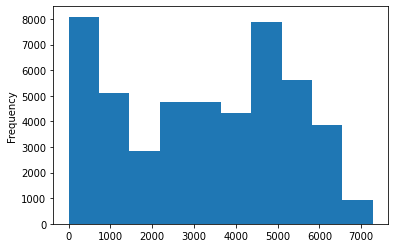

In [6]:
import matplotlib.pyplot as plt
i_94['traffic_volume'].plot.hist()
plt.show()

In [7]:
i_94['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

Entre 2012-10-02 09:00:00 e 2018-09-30 23:00:00, o volume de tráfego horário variou de 0 a 7.280 carros, com média de 3.260 carros.

Cerca de 25% das vezes, havia apenas 1.193 carros ou menos passando pela estação a cada hora – isso provavelmente ocorre durante a noite ou quando uma estrada está em construção. No entanto, cerca de 25% das vezes, o volume de tráfego foi quatro vezes maior (4.933 carros ou mais).

Essa observação dá à nossa análise uma direção interessante: comparar dados diurnos com dados noturnos.

## Volume de tráfego: dia x noite
Começaremos dividindo o conjunto de dados em duas partes:

- Dados diurnos: horas das 7h às 19h (12 horas)
- Dados noturnos: horas das 19h às 7h (12 horas)

Embora este não seja um critério perfeito para distinguir entre o período noturno e o diurno, é um bom ponto de partida.

In [8]:
i_94['date_time'] = pd.to_datetime(i_94['date_time'])

day = i_94.copy()[(i_94['date_time'].dt.hour >= 7) & (i_94['date_time'].dt.hour < 19)]
print(day.shape)

night = i_94.copy()[(i_94['date_time'].dt.hour >= 19) | (i_94['date_time'].dt.hour < 7)]
print(night.shape)

(23877, 9)
(24327, 9)


Essa diferença significativa nos números de linhas entre o dia e a noite se deve a algumas horas de dados ausentes.

Por exemplo, se você observar as linhas 176 e 177 (`i_94.iloc[176:178]`), notará que não há dados por duas horas (4 e 5).

## Volume de tráfego: dia x noite (II)
Agora que isolamos o dia e a noite, veremos os histogramas do volume de tráfego lado a lado usando um gráfico de grade.

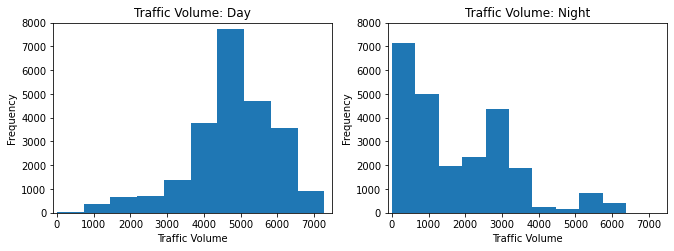

In [9]:
plt.figure(figsize=(11,3.5))

plt.subplot(1, 2, 1)
plt.hist(day['traffic_volume'])
plt.xlim(-100, 7500)
plt.ylim(0, 8000)
plt.title('Traffic Volume: Day')
plt.ylabel('Frequency')
plt.xlabel('Traffic Volume')

plt.subplot(1, 2, 2)
plt.hist(night['traffic_volume'])
plt.xlim(-100, 7500)
plt.ylim(0, 8000)
plt.title('Traffic Volume: Night')
plt.ylabel('Frequency')
plt.xlabel('Traffic Volume')

plt.show()

In [10]:
day['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [11]:
night['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

O histograma que mostra a distribuição do volume de tráfego durante o dia fica distorcido. Isso significa que a maioria dos valores de volume de tráfego são altos – há 4.252 ou mais carros passando pela estação a cada hora 75% do tempo (porque 25% dos valores são inferiores a 4.252).

O histograma que exibe os dados noturnos está inclinado à direita. Isso significa que a maioria dos valores de volume de tráfego são baixos – em 75% das vezes, o número de carros que passavam pela estação a cada hora era inferior a 2.819.

Embora ainda existam medições de mais de 5.000 carros por hora, o tráfego à noite é geralmente leve. Nosso objetivo é encontrar indicadores de tráfego intenso, então vamos nos concentrar apenas nos dados diurnos daqui para frente.

## Indicadores de tempo
Um dos possíveis indicadores de tráfego intenso é o tempo. Pode haver mais pessoas na estrada em um determinado mês, em um determinado dia ou em uma determinada hora do dia.

Vamos ver alguns gráficos de linhas que mostram como o volume de tráfego muda de acordo com o seguinte:

- Mês
- Dia da semana
- Hora do dia

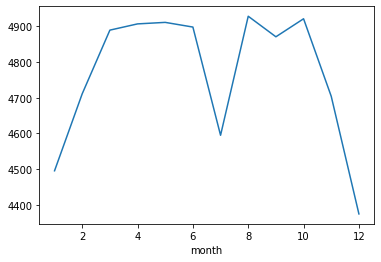

In [12]:
day['month'] = day['date_time'].dt.month
by_month = day.groupby('month').mean()
by_month['traffic_volume'].plot.line()
plt.show()

O tráfego parece menos intenso durante os meses frios (novembro a fevereiro) e mais intenso durante os meses quentes (março a outubro), com uma exceção interessante: julho. Há algo especial em julho? O tráfego é significativamente menos intenso em julho de cada ano?

Para responder à última pergunta, vamos ver como o volume de tráfego mudou a cada ano em julho.

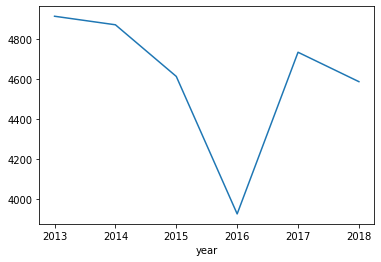

In [13]:
day['year'] = day['date_time'].dt.year
only_july = day[day['month'] == 7]
only_july.groupby('year').mean()['traffic_volume'].plot.line()
plt.show()

Normalmente, o tráfego é bastante intenso em julho, semelhante aos outros meses quentes. A única exceção que vemos é 2016, que teve uma grande queda no volume de tráfego. Uma possível razão para isso é a construção de estradas – este artigo de 2016 apóia essa hipótese.

Como conclusão provisória, podemos dizer que os meses quentes geralmente apresentam tráfego mais pesado em comparação com os meses frios. Em um mês quente, você pode esperar para cada hora do dia um volume de tráfego próximo a 5.000 carros.

## Indicadores de tempo (II)
Vejamos agora um indicador mais granular: número do dia.

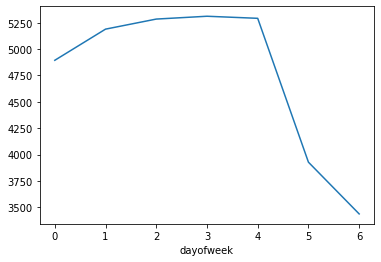

In [14]:
day['dayofweek'] = day['date_time'].dt.dayofweek
by_dayofweek = day.groupby('dayofweek').mean()
by_dayofweek['traffic_volume'].plot.line()
plt.show()

O volume de tráfego é significativamente maior em dias úteis (segunda a sexta). Com exceção de segunda-feira, só vemos valores acima de 5.000 em dias úteis. O trânsito é mais leve nos finais de semana, com valores abaixo de 4.000 carros.

## Indicadores de tempo (III)
Vamos agora ver quais valores temos com base na hora do dia. Os fins de semana, no entanto, arrastarão para baixo os valores médios, então vamos olhar apenas para as médias separadamente.

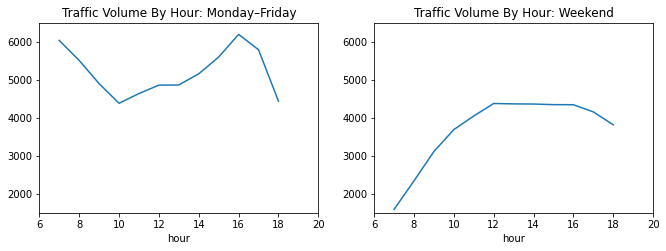

In [15]:
day['hour'] = day['date_time'].dt.hour
bussiness_days = day.copy()[day['dayofweek'] <= 4] # 4 == Friday
weekend = day.copy()[day['dayofweek'] >= 5] # 5 = Saturday
by_hour_business = bussiness_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()


plt.figure(figsize=(11,3.5))

plt.subplot(1, 2, 1)
by_hour_business['traffic_volume'].plot.line()
plt.xlim(6,20)
plt.ylim(1500,6500)
plt.title('Traffic Volume By Hour: Monday–Friday')

plt.subplot(1, 2, 2)
by_hour_weekend['traffic_volume'].plot.line()
plt.xlim(6,20)
plt.ylim(1500,6500)
plt.title('Traffic Volume By Hour: Weekend')

plt.show()

A cada hora do dia, o volume de tráfego é geralmente maior durante os dias úteis em comparação aos finais de semana. Como de alguma forma esperado, o  horário de pico é por volta das 7 e 16 – quando a maioria das pessoas viaja de casa para o trabalho e volta. Vemos volumes de mais de 6.000 carros nas horas de pico.

Para resumir, encontramos alguns indicadores de tráfego intenso relacionados ao tempo:

- O tráfego é geralmente mais intenso durante os meses quentes (março a outubro) em comparação com os meses frios (novembro a fevereiro).

- O tráfego costuma ser mais intenso em dias úteis em comparação aos finais de semana.

Nos dias úteis, as horas de ponta são por volta das 7 e 16.

## Indicadores climáticos

Outro possível indicador de tráfego intenso é o clima. O conjunto de dados nos fornece algumas colunas úteis sobre clima: `temp`, `rain_1h`, `snow_1h`, `clouds_all`, `weather_main`, `weather_description`.

Algumas dessas colunas são numéricas, então vamos começar procurando seus valores de correlação com `traffic_volume`.

In [16]:
day.corr()['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
month            -0.022337
year             -0.003557
dayofweek        -0.416453
hour              0.172704
Name: traffic_volume, dtype: float64

A temperatura mostra a correlação mais forte com um valor de apenas +0.13. As outras colunas relevantes (`rain_1h`, `snow_1h`, `clouds_all`) não mostram nenhuma correlação forte com `traffic_value`.

Vamos gerar um gráfico de dispersão para visualizar a correlação entre temp e `traffic_volume`.

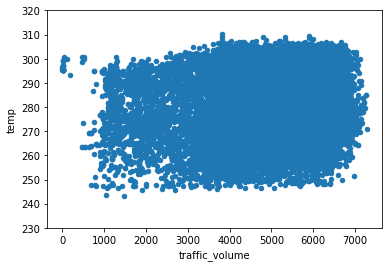

In [17]:
day.plot.scatter('traffic_volume', 'temp')
plt.ylim(230, 320) # two wrong 0K temperatures mess up the y-axis
plt.show()

Podemos concluir que a temperatura não parece um indicador sólido de tráfego intenso.

Vejamos agora as outras colunas relacionadas ao clima: `weather_main` e `weather_description`.

## Tipos de clima
Para começar, vamos agrupar os dados por weather_main e observar as médias do `traffic_volume`.

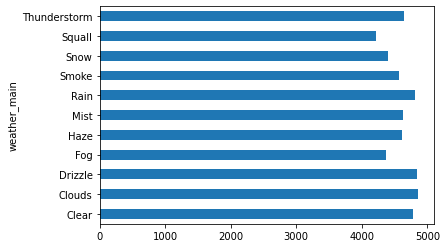

In [18]:
by_weather_main = day.groupby('weather_main').mean()
by_weather_main['traffic_volume'].plot.barh()
plt.show()

Parece que não há nenhum tipo de clima em que o volume de tráfego exceda 5.000 carros. Isso torna mais difícil encontrar um indicador de tráfego pesado. Vamos também agrupar por `weather_description`, que tem uma classificação de clima mais granular.

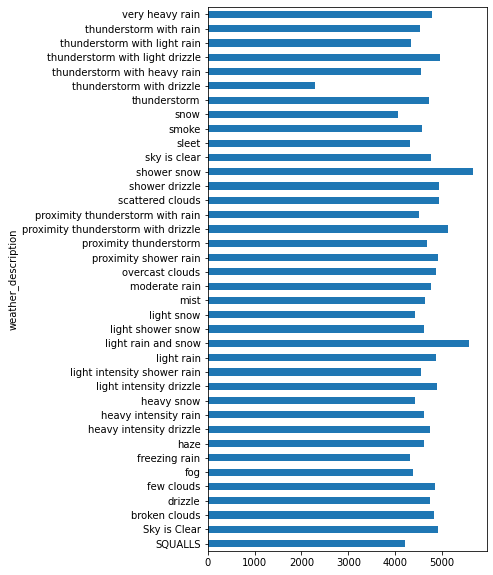

In [19]:
by_weather_description = day.groupby('weather_description').mean()
by_weather_description['traffic_volume'].plot.barh(figsize=(5,10))
plt.show()

Parece que existem três tipos de clima em que o volume de tráfego excede 5.000:

- Chuva de neve
- Chuva leve e neve
- Tempestade de proximidade com chuvisco

Não está claro por que esses tipos de clima têm os valores médios de tráfego mais altos - esse é um clima ruim, mas não tão ruim assim. Talvez mais pessoas tirem seus carros da garagem quando o tempo estiver ruim em vez de andar de bicicleta ou caminhar.

## Conclusão
Neste projeto, tentamos encontrar alguns indicadores de tráfego intenso na rodovia interestadual I-94. Conseguimos encontrar dois tipos de indicadores:

- Indicadores de tempo
  * O tráfego é geralmente mais intenso durante os meses quentes (março a outubro) em comparação com os meses frios (novembro a fevereiro).
  * O tráfego costuma ser mais intenso em dias úteis em comparação aos finais de semana.
  * Nos dias úteis, as horas de ponta são por volta das 7 e 16.

- Indicadores climáticos
  * Chuva de neve
  * Chuva leve e neve
  * Tempestade de proximidade com chuvisco